In [1]:
#path
import os
from os.path import isdir, join
from pathlib import Path

# Scientific Math 
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

#Deep learning
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
import tensorflow as tf

import random
import copy
import librosa


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
print(os.listdir("../data"))

['processed', 'test', 'train']


In [3]:
train_audio_path = '../data/train/audio/'
print(os.listdir(train_audio_path))

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


### Load Data
Load everything from scratch

target list is ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown list is other
silence will be made from '_background_noise_'

Train data's sampling rate is 16000Hz, but for making lower computation cost, Resample to 8000hz

After training, test set also will resample to 8000Hz

In [4]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs[1:])))
print(dirs)

Number of labels: 30
['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [5]:
all_wav = []
unknown_wav = []
label_all = []
label_value = {}
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown_list = [d for d in dirs if d not in target_list and d != '_background_noise_' ]
print('target_list : ',end='')
print(target_list)
print('unknowns_list : ', end='')
print(unknown_list)
print('silence : _background_noise_')
i=0;
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
background_noise = []
for wav in background : 
    samples, sample_rate = librosa.load(join(join(train_audio_path,'_background_noise_'),wav))
    samples = librosa.resample(samples, sample_rate, 8000)
    background_noise.append(samples)

target_list : ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknowns_list : ['bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']
silence : _background_noise_


### load from scratch

In [6]:
for direct in dirs[1:]:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    label_value[direct] = i
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")
    for wav in waves:
        samples, sample_rate = librosa.load(join(join(train_audio_path,direct),wav), sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) != 8000 : 
            continue
            
        if direct in unknown_list:
            unknown_wav.append(samples)
        else:
            label_all.append(direct)
            all_wav.append([samples, direct])

1:bed 

KeyboardInterrupt: 

split wav, label

In [7]:
wav_all = np.reshape(np.delete(all_wav,1,1),(len(all_wav)))
label_all = [i for i in np.delete(all_wav,0,1).tolist()]

### Saving preprocessed files
Save data loaded from scratch

In [8]:
np.save("../data/processed/wav_all.npy", wav_all)
np.save("../data/processed/label_all.npy", label_all)
np.save("../data/processed/unknown_wav.npy", unknown_wav)

In [29]:
wav_all.shape
len(wav_all[0])
len(label_all)
len(label_all[0])
len(unknown_wav)
len(unknown_wav[0])
type(label_all)
type(unknown_wav)
type(label_all[1])
type(unknown_wav[1])
unknown_wav[1].shape

(21312,)

8000

21312

1

36940

8000

list

list

list

numpy.ndarray

(8000,)

### Loading preprocessed files

In [6]:
wav_all = np.load("../data/processed/wav_all.npy", allow_pickle=True)
label_all = np.load("../data/processed/label_all.npy").tolist()
unknown_wav = np.load("../data/processed/unknown_wav.npy").tolist()
unknown_wav = [np.asarray(elem) for elem in unknown_wav]

In [7]:
len(label_all)

21312

In [8]:
wav_all.shape
len(wav_all[0])
len(label_all)
len(label_all[0])
len(unknown_wav)
len(unknown_wav[0])
type(label_all)
type(unknown_wav)
type(label_all[1])
type(unknown_wav[1])
unknown_wav[1].shape

(21312,)

8000

21312

1

36940

8000

list

list

list

numpy.ndarray

(8000,)

In [9]:
np.unique(label_all)

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up',
       'yes'], dtype='<U5')

## Create exemplary spectogram

In [10]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
#     noverlap = int(nperseg//8)
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
def log_specgram_freq_160(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = 256
    noverlap = 256//8
#     nperseg = int(round(window_size * sample_rate / 1e3))
#     noverlap = int(round(step_size * sample_rate / 1e3))
#     noverlap = int(nperseg//8)
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

(8000,)

[   0.   25.   50.   75.  100.  125.  150.  175.  200.  225.  250.  275.
  300.  325.  350.  375.  400.  425.  450.  475.  500.  525.  550.  575.
  600.  625.  650.  675.  700.  725.  750.  775.  800.  825.  850.  875.
  900.  925.  950.  975. 1000. 1025. 1050. 1075. 1100. 1125. 1150. 1175.
 1200. 1225. 1250. 1275. 1300. 1325. 1350. 1375. 1400. 1425. 1450. 1475.
 1500. 1525. 1550. 1575. 1600. 1625. 1650. 1675. 1700. 1725. 1750. 1775.
 1800. 1825. 1850. 1875. 1900. 1925. 1950. 1975. 2000. 2025. 2050. 2075.
 2100. 2125. 2150. 2175. 2200. 2225. 2250. 2275. 2300. 2325. 2350. 2375.
 2400. 2425. 2450. 2475. 2500. 2525. 2550. 2575. 2600. 2625. 2650. 2675.
 2700. 2725. 2750. 2775. 2800. 2825. 2850. 2875. 2900. 2925. 2950. 2975.
 3000. 3025. 3050. 3075. 3100. 3125. 3150. 3175. 3200. 3225. 3250. 3275.
 3300. 3325. 3350. 3375. 3400. 3425. 3450. 3475. 3500. 3525. 3550. 3575.
 3600. 3625. 3650. 3675. 3700. 3725. 3750. 3775. 3800. 3825. 3850. 3875.
 3900. 3925. 3950. 3975. 4000.]
[0.02 0.05 0.08 0.1

(33, 161)

Text(0.5, 1.0, 'Raw wave of ')

Text(0, 0.5, 'Amplitude')

Text(0.5, 1.0, 'Spectrogram of ')

Text(0, 0.5, 'Freqs in Hz')

Text(0.5, 0, 'Seconds')

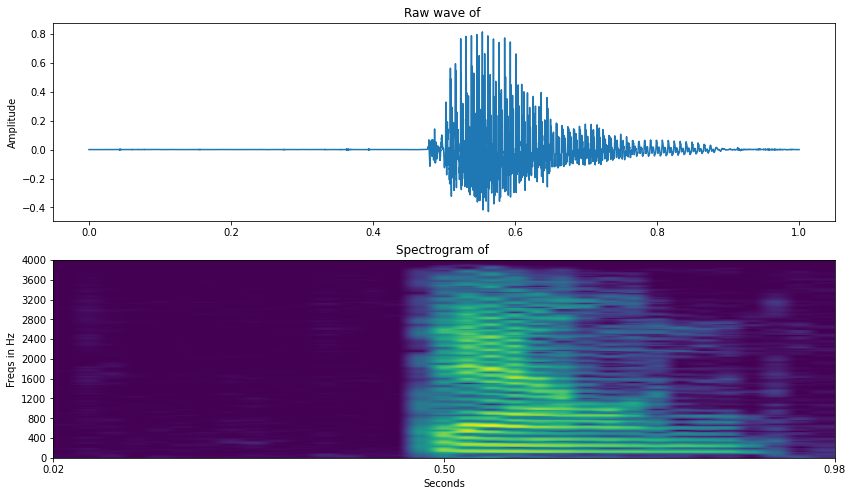

In [11]:
samples, sample_rate = wav_all[0], 8000
samples.shape
freqs, times, spectrogram = log_specgram(samples, sample_rate, window_size=40, step_size=10)
# freqs, times, spectrogram = log_specgram_freq_160(samples, sample_rate, window_size=39, step_size=10)
print(freqs)
print(times)
spectrogram.shape
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### Data Augmentation

For Data Augmentation. I will mix train wav, and same length(1 sec) noise(10%) from '_background_noise_'


In [12]:
#Random pick start point
def get_one_noise(noise_num = 0):
    selected_noise = background_noise[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [13]:
max_ratio = 0.1
noised_wav = []
augment = 1
delete_index = []
for i in range(augment):
    new_wav = []
    noise = get_one_noise(i)
    for i, s in enumerate(wav_all):
        if len(s) != 8000:
            delete_index.append(i)
            continue
        s = s + (max_ratio * noise)
        noised_wav.append(s)
np.delete(wav_all, delete_index)
np.delete(label_all, delete_index)

array([array([-1.27418665e-04, -1.12644804e-04, -1.86756923e-04, ...,
       -1.62762426e-05, -4.93293861e-04, -3.55132594e-04], dtype=float32),
       array([-0.00306999, -0.00410808, -0.00331036, ..., -0.00467804,
       -0.00421489, -0.00610053], dtype=float32),
       array([ 0.00015912,  0.00111388, -0.00125856, ..., -0.0095068 ,
        0.01478101,  0.03418859], dtype=float32),
       ...,
       array([-1.8530698e-05, -1.7116408e-05, -1.5449716e-04, ...,
        2.0603633e-04,  1.4838617e-04,  3.0142363e-04], dtype=float32),
       array([-0.00013034, -0.00023936, -0.00036349, ...,  0.00059682,
        0.00044404,  0.00033889], dtype=float32),
       array([ 0.00037031,  0.00076071,  0.00072666, ..., -0.00076363,
       -0.00083591, -0.0005128 ], dtype=float32)], dtype=object)

array(['down', 'down', 'down', ..., 'yes', 'yes', 'yes'], dtype='<U5')

In [14]:
wav_vals = np.array([x for x in wav_all])
label_vals = [x for x in label_all]
wav_vals.shape

(21312, 8000)

In [15]:
labels = copy.deepcopy(label_vals)
for _ in range(augment):
    label_vals = np.concatenate((label_vals, labels), axis = 0)
label_vals = label_vals.reshape(-1,1)

Random sampling from unknown wav data


In [16]:
#knowns audio random sampling
unknown = unknown_wav
np.random.shuffle(unknown_wav)
unknown = np.array(unknown)
unknown = unknown[:2000*(augment+1)]
unknown_label = np.array(['unknown' for _ in range(2000*(augment+1))])
unknown_label = unknown_label.reshape(2000*(augment+1),1)

May Some wav data has different length. So, Delete it

In [17]:
delete_index = []
for i,w in enumerate(unknown):
    if len(w) != 8000:
        delete_index.append(i)
unknown = np.delete(unknown, delete_index, axis=0)

Random sampling from '_background_noise_' 

Random pick background noise 


In [18]:
#silence audio
silence_wav = []
num_wav = (2000*(augment+1))//len(background_noise)
for i, _ in enumerate(background_noise):
    for _ in range((2000*(augment+1))//len(background_noise)):
        silence_wav.append(get_one_noise(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(num_wav*len(background_noise))])
silence_label = silence_label.reshape(-1,1)
silence_wav.shape

(3996, 8000)

In [19]:
wav_vals    = np.reshape(wav_vals,    (-1, 8000))
noised_wav  = np.reshape(noised_wav,  (-1, 8000))
unknown       = np.reshape(unknown,   (-1, 8000))
silence_wav = np.reshape(silence_wav, (-1, 8000))

Check Dimensions

In [20]:
print(wav_vals.shape)
print(noised_wav.shape)
print(unknown.shape)
print(silence_wav.shape)

(21312, 8000)
(21312, 8000)
(4000, 8000)
(3996, 8000)


In [21]:
print(label_vals.shape)
print(unknown_label.shape)
print(silence_label.shape)

(42624, 1)
(4000, 1)
(3996, 1)


Concatenate wavs, labels 

In [22]:
wav_vals = np.concatenate((wav_vals, noised_wav), axis = 0)
wav_vals = np.concatenate((wav_vals, unknown), axis = 0)
wav_vals = np.concatenate((wav_vals, silence_wav), axis = 0)

In [23]:
label_vals = np.concatenate((label_vals, unknown_label), axis = 0)
label_vals = np.concatenate((label_vals, silence_label), axis = 0)

In [24]:
print(len(wav_vals))
print(len(label_vals))

50620
50620


### Prepare Train

In [25]:
train_wav, test_wav, train_label, test_label = train_test_split(wav_vals, label_vals, 
                                                                    test_size=0.2,
                                                                    random_state = 1993,
                                                                    shuffle=True)

In [26]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 512
drop_out_rate = 0.5
input_shape = (8000,1)

In [27]:
#For Conv1D add Channel
train_wav = train_wav.reshape(-1,8000,1)
test_wav = test_wav.reshape(-1,8000,1)

In [28]:
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

### Create dict of names

In [29]:
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

In [30]:
#Make Label data 'string' -> 'class num'
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

train_label_scalar = train_label
test_label_scalar = test_label
#Make Label data 'class num' -> 'One hot vector'
train_label = keras.utils.to_categorical(train_label, len(label_value))
test_label = keras.utils.to_categorical(test_label, len(label_value))

In [31]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (40496, 8000, 1)
Train_Label Demension : (40496, 12)
Test_Wav Demension : (10124, 8000, 1)
Test_Label Demension : (10124, 12)
Number Of Labels : 12


# Simple Conv1D model

In [59]:
#Conv1D Model
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(10)(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
# x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])


In [60]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3995, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3995, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1994, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1994, 16)          0     

In [61]:
history = model.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=100,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/100
  512/40496 [..............................] - ETA: 10:19

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv1d/conv1d (defined at <ipython-input-61-cf1815e6ba93>:4) ]] [Op:__inference_distributed_function_1521]

Function call stack:
distributed_function


In [ ]:
model.save("../models/conv/baseline.h5")

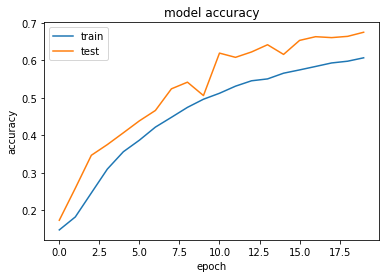

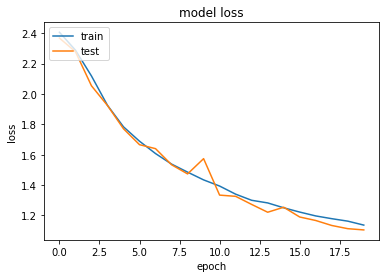

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

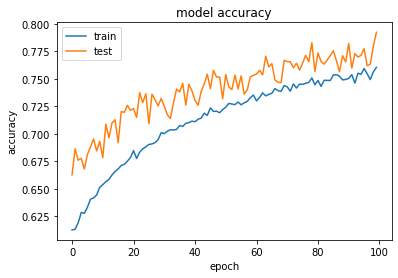

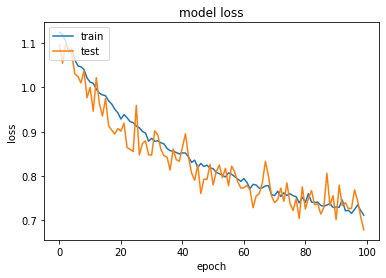

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model with LSTM cells

In [34]:
#Conv1D Model
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(10)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])


In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3995, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3995, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1994, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1994, 16)          0     

#### Callbacks

In [39]:
run_path = "../models/rec"
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=0)
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{val_accuracy:03f}.h5'),
                           save_best_only=True, monitor='accuracy', patience=7)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4)

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [40]:
history = model.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=100,
          callbacks=callbacks,
          verbose=1)
model.save("../models/rec/baseline.h5")

Train on 40496 samples, validate on 10124 samples
Epoch 1/100
40496/40496 [==============================] - 23s 561us/sample - loss: 2.3591 - accuracy: 0.1563 - val_loss: 2.1991 - val_accuracy: 0.2250
Epoch 2/100
40496/40496 [==============================] - 16s 389us/sample - loss: 2.1149 - accuracy: 0.2346 - val_loss: 1.9488 - val_accuracy: 0.3107ss: 2.1151 - accuracy: 0.23
Epoch 3/100
40496/40496 [==============================] - 16s 392us/sample - loss: 1.9243 - accuracy: 0.2974 - val_loss: 1.7401 - val_accuracy: 0.3830
Epoch 4/100
40496/40496 [==============================] - 16s 393us/sample - loss: 1.7081 - accuracy: 0.3758 - val_loss: 1.4283 - val_accuracy: 0.495410s - loss: 1.815 - ETA: 8s - loss: 1.7920 - accuracy: 0.34 - ETA: 8s - loss: 1.7900 - accuracy - ETA: 3s - loss: 1.7415 - accuracy: 0. - ETA: 
Epoch 5/100
40496/40496 [==============================] - 16s 394us/sample - loss: 1.5010 - accuracy: 0.4563 - val_loss: 1.2972 - val_accuracy: 0.5501
Epoch 6/100
40496/40

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

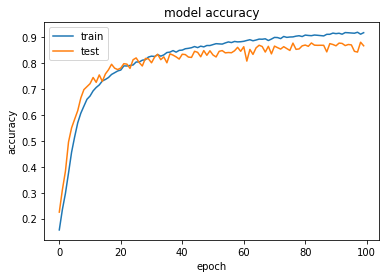

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

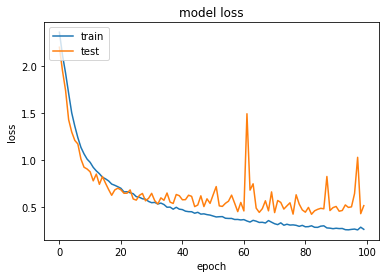

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Models for spectograms

In [32]:
del(wav_vals)

In [33]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
#     noverlap = int(nperseg//8)
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

(8000,)

(161,)
(33,)


(33, 161)

Text(0.5, 1.0, 'Raw wave of ')

Text(0, 0.5, 'Amplitude')

Text(0.5, 1.0, 'Spectrogram of ')

Text(0, 0.5, 'Freqs in Hz')

Text(0.5, 0, 'Seconds')

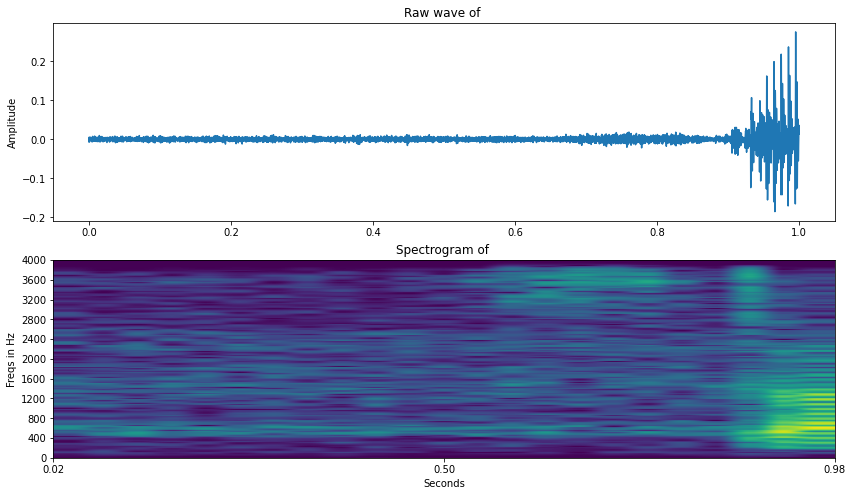

In [36]:
samples, sample_rate = np.squeeze(train_wav[0]), 8000
samples.shape
freqs, times, spectrogram = log_specgram(samples, sample_rate, window_size=40, step_size=10)
# freqs, times, spectrogram = log_specgram(samples, sample_rate, window_size=12, step_size=3)
print(freqs.shape)
print(times.shape)
spectrogram.shape
# spectrogram = spectrogram[10:,:] # first axis is time
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [37]:
np.squeeze(train_wav[i]).shape

(8000,)

In [ ]:
spectograms_train = [log_specgram(np.squeeze(elem), sample_rate, window_size=12, step_size=3)[2][:, 1:]\
                     for elem in train_wav]
spectograms_train = np.asarray(spectograms_train)
spectograms_train.shape
spectograms_val = [log_specgram(np.squeeze(elem), sample_rate, window_size=12, step_size=3)[2][:, 1:]\
                     for elem in test_wav]
spectograms_val = np.asarray(spectograms_val)
spectograms_val.shape

In [37]:
input_shape = (110, 49, 1)

In [39]:
#Conv2D Model
input_tensor = Input(shape=(input_shape))

x = layers.BatchNormalization(axis=2)(input_tensor)

x = layers.Conv2D(16, (11,49), padding='valid', activation='relu', strides=1)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(1, x.shape[2])(x)

# x = layers.Conv2D(32, (3,40), activation='relu')(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(1, x.shape[2])(x)

x = layers.Reshape((100, 16))(x)
# x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
# x = layers.MaxPooling1D(10)(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])


In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 110, 49, 1)]      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 49, 1)        196       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 1, 16)        8640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 1, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 1, 16)        64        
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 16)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          148480

#### Callbacks

In [41]:
run_path = "../models/spect2"
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=10, verbose=0)
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{val_accuracy:03f}.h5'),
                           save_best_only=True, monitor='accuracy', patience=7)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4)

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [42]:
spectograms_train = np.squeeze(spectograms_train)
spectograms_val = np.squeeze(spectograms_val)
spectograms_train.shape

(40496, 110, 49)

In [43]:
spectograms_train = np.expand_dims(spectograms_train, axis=3)
spectograms_val = np.expand_dims(spectograms_val, axis=3)
spectograms_train.shape

(40496, 110, 49, 1)

#### Calculate class weights

In [44]:
train_label_scalar

array([ 8,  5,  1, ...,  3, 11,  2])

In [45]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_label_scalar),
                                                 train_label_scalar)

In [46]:
history = model.fit(spectograms_train, train_label, validation_data=[spectograms_val, test_label],
          batch_size=batch_size, 
          epochs=100,
          callbacks=callbacks,
#           class_weights = class_weights,
          verbose=1)

Train on 40496 samples, validate on 10124 samples
Epoch 1/100
40496/40496 [==============================] - 63s 2ms/sample - loss: 1.8491 - accuracy: 0.3639 - val_loss: 2.9732 - val_accuracy: 0.1175
Epoch 2/100
40496/40496 [==============================] - 82s 2ms/sample - loss: 1.1088 - accuracy: 0.6431 - val_loss: 1.5281 - val_accuracy: 0.4854
Epoch 3/100
40496/40496 [==============================] - 78s 2ms/sample - loss: 0.8253 - accuracy: 0.7456 - val_loss: 0.9508 - val_accuracy: 0.7487
Epoch 4/100
40496/40496 [==============================] - 85s 2ms/sample - loss: 0.7038 - accuracy: 0.7907 - val_loss: 0.5054 - val_accuracy: 0.8457
Epoch 5/100
40496/40496 [==============================] - 91s 2ms/sample - loss: 0.6510 - accuracy: 0.8089 - val_loss: 0.4900 - val_accuracy: 0.8512
Epoch 6/100
40496/40496 [==============================] - 90s 2ms/sample - loss: 0.5767 - accuracy: 0.8321 - val_loss: 0.4345 - val_accuracy: 0.8609
Epoch 7/100
40496/40496 [=========================

KeyError: 'val_accuracy'

# Predict on test set (spectrogram )

## Load data fast

In [47]:
saved = np.load("../data/test/all_wavs.npy", allow_pickle=True)
saved.shape

(158538, 2)

In [48]:
saved = saved.tolist()

In [49]:
wavs_names = []
wavs = []
for i in range(len(saved)):
    wavs_names.append(saved[i][0])
    wavs.append(saved[i][1])

In [50]:
wavs = np.asarray(wavs)
wavs.shape

(158538, 8000)

In [52]:
n_steps = wavs.shape[0]//1024
n_steps

154

In [ ]:
preds_all = []
sample_rate = 8000
for i in range(n_steps+1):
    print(i)
    if i==n_steps:
        spectograms_test = [log_specgram(np.squeeze(elem), sample_rate, window_size=12, step_size=3)[2]\
                         for elem in wavs[i*1024:]]
    else:
        spectograms_test = [log_specgram(np.squeeze(elem), sample_rate, window_size=12, step_size=3)[2]\
                         for elem in wavs[i*1024:i*1024 + 1024]]
    spectograms_test = np.asarray(spectograms_test)
    spectograms_test = np.expand_dims(spectograms_test, axis=3)
    spectograms_test.shape
    preds_all.append(model.predict(spectograms_test))
preds_all = [item for sublist in preds_all for item in sublist]

In [ ]:
preds_all = np.asarray(preds_all)
preds_all.shape
predictions = preds_all

## Predictions to submission file

In [18]:
label_dict = {'yes': 0,
             'no': 1,
             'up': 2,
             'down': 3,
             'left': 4,
             'right': 5,
             'on': 6,
             'off': 7,
             'stop': 8,
             'go': 9,
             'unknown': 10,
             'silence': 11}

In [22]:
num_to_label = {value: key for key, value in label_dict.items()}
num_to_label

{0: 'yes',
 1: 'no',
 2: 'up',
 3: 'down',
 4: 'left',
 5: 'right',
 6: 'on',
 7: 'off',
 8: 'stop',
 9: 'go',
 10: 'unknown',
 11: 'silence'}

In [24]:
predicted_labels = [num_to_label[num] for num in predictions.argmax(1)]

['no',
 'unknown',
 'unknown',
 'silence',
 'unknown',
 'on',
 'unknown',
 'unknown',
 'go',
 'unknown',
 'off',
 'unknown',
 'unknown',
 'yes',
 'no',
 'stop',
 'right',
 'down',
 'go',
 'stop',
 'unknown',
 'unknown',
 'right',
 'unknown',
 'unknown',
 'yes',
 'unknown',
 'on',
 'off',
 'down',
 'unknown',
 'unknown',
 'unknown',
 'stop',
 'down',
 'unknown',
 'go',
 'yes',
 'silence',
 'right',
 'off',
 'down',
 'unknown',
 'off',
 'unknown',
 'off',
 'yes',
 'no',
 'unknown',
 'off',
 'unknown',
 'unknown',
 'stop',
 'go',
 'on',
 'unknown',
 'on',
 'unknown',
 'left',
 'unknown',
 'unknown',
 'stop',
 'unknown',
 'up',
 'unknown',
 'off',
 'yes',
 'left',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'off',
 'unknown',
 'silence',
 'unknown',
 'no',
 'unknown',
 'off',
 'unknown',
 'no',
 'unknown',
 'unknown',
 'unknown',
 'go',
 'unknown',
 'down',
 'no',
 'off',
 'silence',
 'on',
 'left',
 'unknown',
 'down',
 'on',
 'unknown',
 'go',
 'unknown',
 'unknown',
 'on',
 'silenc

In [28]:
submission_file = pd.read_csv(os.path.join("../data/test", "sample_submission.csv"))
submission_file.head()

,fname,label
0,clip_000044442.wav,silence
1,clip_0000adecb.wav,silence
2,clip_0000d4322.wav,silence
3,clip_0000fb6fe.wav,silence
4,clip_0001d1559.wav,silence


## Check if order is allright

In [32]:
submission_file.fname.values.tolist() == wavs_names

True

In [33]:
submission_file["label"] = predicted_labels

In [34]:
submission_file.to_csv(os.path.join("../submissions", "submission_lstm.csv"), index=False)